# Pregunta 2:
### ¿Podemos identificar clusters o grupos naturales de películas blockbuster según características de género, presupuesto y rating?
# Técnica:
### Análisis mediante K-Means Clustering (Aprendizaje No Supervisado)

## Configuración inicial

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Crear carpeta para gráficos de esta pregunta
graphics_folder = 'graphics/pregunta2'
if not os.path.exists(graphics_folder):
    os.makedirs(graphics_folder)
    print(f"✓ Carpeta creada: {graphics_folder}/")

# Crear carpeta para resultados
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"✓ Carpeta creada: {results_folder}/")

## Cargar datos limpios

In [90]:
print("📂 CARGANDO DATOS PROCESADOS...")
try:
    # Intentar cargar desde la carpeta data
    df = pd.read_csv('data/Blockbusters_Limpio.csv')
    print(f"✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv")
    print(f"  • {df.shape[0]} películas, {df.shape[1]} variables")
    
    # Verificar que tenemos las columnas necesarias
    required_columns = ['film_budget', 'imdb_rating', 'genre_1']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"⚠ Advertencia: Faltan columnas {missing_columns}")
            
except FileNotFoundError:
    print("⚠ No se encontró el archivo limpio, cargando original...")
    try:
        df = pd.read_csv('Blockbusters_2019-1977.csv', encoding='latin1')
        
        # Limpiar columnas numéricas
        columnas_numericas = ['film_budget', 'worldwide_gross', 'domestic_gross']
        for col in columnas_numericas:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        print("✓ Datos originales cargados y transformados")
        
    except FileNotFoundError:
        print("❌ ERROR: No se encontró ningún archivo de datos")
        print("  Por favor, ejecuta primero Analisis_Blockbusters_Main.ipynb")
        raise

📂 CARGANDO DATOS PROCESADOS...
✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv
  • 430 películas, 18 variables


##  Descripción de variables y metodología

## Variables utilizadas

El análisis de clustering se realizó sobre un subconjunto de variables del conjunto de datos Blockbusters (1977–2019), seleccionadas por su relevancia analítica y su capacidad para capturar dimensiones clave de las películas. En particular, se incluyeron variables económicas, de calidad percibida y de tipo narrativo.

El presupuesto de la película (film_budget) se utilizó como variable numérica continua y representa la escala económica de la producción, así como el nivel de inversión por parte de los estudios. En el caso de los blockbusters, es un factor central para diferenciar estrategias de producción.

La calificación de IMDb (imdb_rating), también de naturaleza numérica, refleja la recepción del público a partir de valoraciones de usuarios. Esta variable se interpreta como una medida de la calidad percibida de la película, asociada a aspectos como el guion, la dirección y las actuaciones, y resulta particularmente relevante porque no depende directamente del nivel de inversión.

Finalmente, se incorporó el género principal de la película (genre_1) como variable categórica, ya que describe el tipo narrativo dominante. El género es una dimensión clave en la industria cinematográfica, dado que algunos géneros tienden a asociarse sistemáticamente con mayores presupuestos y diferentes perfiles de audiencia, como ocurre, por ejemplo, con la ciencia ficción frente al drama.

## Justificación de la metodología

Se optó por aplicar un análisis de clustering no supervisado debido al carácter exploratorio del estudio. No se cuenta con etiquetas predefinidas que clasifiquen a las películas en “tipos de blockbuster”, por lo que el objetivo es identificar patrones naturales en los datos sin imponer categorías a priori.

Además, las películas blockbuster presentan una naturaleza multidimensional, ya que difieren simultáneamente en presupuesto, calidad percibida y género. El clustering permite capturar estas variaciones conjuntas y analizar cómo se combinan estas características, algo que no puede lograrse mediante análisis univariados o bivariados.

Por último, se espera una alta heterogeneidad dentro del conjunto de blockbusters. Existen películas con presupuestos extremadamente altos pero recepción crítica moderada, otras con presupuestos más contenidos y excelente valoración, y otras que, pese a una inversión menor, logran una gran aceptación popular. El clustering permite identificar estos perfiles diferenciados de manera empírica.

## Algoritmo de clustering: K-Means

Para la segmentación se utilizó el algoritmo K-Means, debido a su eficiencia computacional y a su facilidad de interpretación. Este método resulta adecuado para conjuntos de datos con cientos de observaciones y permite describir cada grupo mediante centroides que representan valores promedio de presupuesto y calificación, lo cual facilita la comunicación de los resultados.

K-Means es ampliamente utilizado en contextos de segmentación industrial y de mercado, incluido el análisis de productos culturales como las películas, lo que refuerza su pertinencia para este estudio.

### -Preprocesamiento de los datos

Antes de aplicar el algoritmo, se realizó un preprocesamiento adecuado de las variables. Las variables numéricas, presupuesto y calificación IMDb, fueron estandarizadas mediante StandardScaler con el fin de asegurar que ambas contribuyeran equitativamente al cálculo de distancias. Sin esta estandarización, el presupuesto —medido en millones de dólares— habría dominado el proceso de clustering frente a la calificación, que se encuentra en una escala mucho más reducida.

Por otro lado, la variable categórica genre_1 se transformó, generando variables dummy. Esto se hace porque los algoritmos de clustering como K-means solo pueden trabajar con datos numéricos, ya que se basan en medidas de distancia (como la euclidiana). Las variables dummy permiten representar cada categoría como un vector binario, donde un 1 indica la presencia de un género y un 0 su ausencia. Esta transformación asegura que la información categórica se incorpore de manera que el algoritmo pueda distinguir patrones de género entre las películas sin introducir ordenamiento arbitrario entre las categorías.


PREPROCESAMIENTO Y SELECCIÓN DE K ÓPTIMO 
✓ Presupuesto convertido a numérico
✓ Datos preparados: 430 películas
  • 0 películas descartadas por datos incompletos
✓ Variables dummy creadas para genre_1
✓ Variables numéricas estandarizadas

Evaluando k de 2 a 6...
  k=2: Silhouette=0.284, Davies-Bouldin=1.387, Calinski-Harabasz=178.8
  k=3: Silhouette=0.264, Davies-Bouldin=1.272, Calinski-Harabasz=185.8
  k=4: Silhouette=0.240, Davies-Bouldin=1.294, Calinski-Harabasz=162.1
  k=5: Silhouette=0.215, Davies-Bouldin=1.453, Calinski-Harabasz=148.9
  k=6: Silhouette=0.247, Davies-Bouldin=1.362, Calinski-Harabasz=139.2

✓ MEJOR NÚMERO DE CLUSTERS: 2
  Silhouette score: 0.284
  Davies-Bouldin Index: 1.387
  Calinski-Harabasz Index: 178.8

CREACIÓN DE VISUALIZACIONES


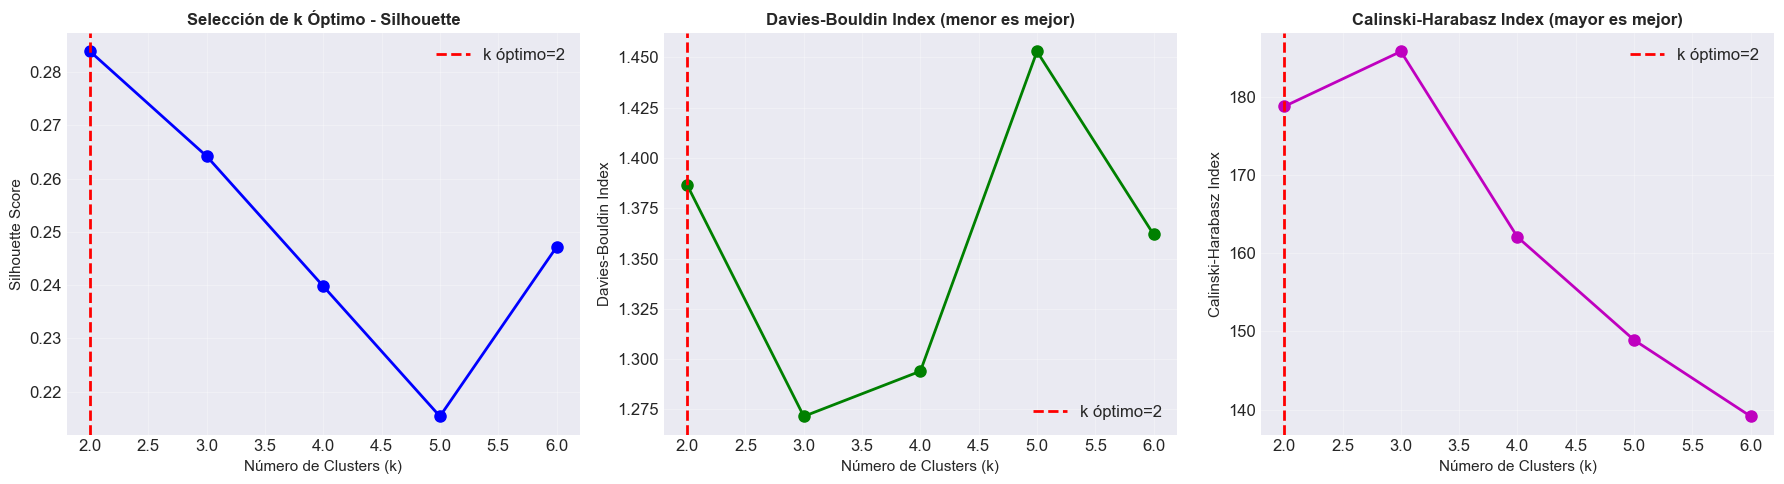

In [91]:
print("\n" + "="*70)
print("PREPROCESAMIENTO Y SELECCIÓN DE K ÓPTIMO ")
print("="*70)

# LIMPIEZA CRÍTICA - Convertir presupuesto a numérico
df['film_budget'] = (
    df['film_budget']
    .astype(str)
    .str.replace(',', '')
    .astype(float)
)
print("✓ Presupuesto convertido a numérico")

# Selección de variables
df_cluster = df[['film_budget', 'imdb_rating', 'genre_1']].dropna()

print(f"✓ Datos preparados: {len(df_cluster)} películas")
print(f"  • {len(df) - len(df_cluster)} películas descartadas por datos incompletos")

# Variables dummy para el género principal
df_cluster = pd.get_dummies(
    df_cluster,
    columns=['genre_1'],
    drop_first=False
)

print("✓ Variables dummy creadas para genre_1")

# Escalado de variables numéricas
scaler = StandardScaler()
df_cluster[['film_budget', 'imdb_rating']] = scaler.fit_transform(
    df_cluster[['film_budget', 'imdb_rating']]
)

#print(df_cluster,scaler)
print("✓ Variables numéricas estandarizadas")

# Matriz final para clustering
X_cluster = df_cluster.values


sil_scores = {}
davies_bouldin_scores = {}
calinski_harabasz_scores = {}

print("\nEvaluando k de 2 a 6...")

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)

    sil = silhouette_score(X_cluster, labels)
    db = davies_bouldin_score(X_cluster, labels)
    ch = calinski_harabasz_score(X_cluster, labels)

    sil_scores[k] = sil
    davies_bouldin_scores[k] = db
    calinski_harabasz_scores[k] = ch

    print(f"  k={k}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.1f}")

best_k = max(sil_scores, key=sil_scores.get)



print(f"\n✓ MEJOR NÚMERO DE CLUSTERS: {best_k}")
print(f"  Silhouette score: {sil_scores[best_k]:.3f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_scores[best_k]:.3f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz_scores[best_k]:.1f}")

print("\n" + "="*70)
print("CREACIÓN DE VISUALIZACIONES")
print("="*70)

# Gráfico 1: Elbow Method (Silhouette scores)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette scores
ax1 = axes[0]
ks = list(sil_scores.keys())
scores = list(sil_scores.values())
ax1.plot(ks, scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'k óptimo={best_k}')
ax1.set_xlabel('Número de Clusters (k)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Selección de k Óptimo - Silhouette', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Davies-Bouldin Index (menor es mejor)
ax2 = axes[1]
db_scores = [davies_bouldin_scores[k] for k in ks]
ax2.plot(ks, db_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'k óptimo={best_k}')
ax2.set_xlabel('Número de Clusters (k)', fontsize=11)
ax2.set_ylabel('Davies-Bouldin Index', fontsize=11)
ax2.set_title('Davies-Bouldin Index (menor es mejor)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calinski-Harabasz Index (mayor es mejor)
ax3 = axes[2]
ch_scores = [calinski_harabasz_scores[k] for k in ks]
ax3.plot(ks, ch_scores, 'mo-', linewidth=2, markersize=8)
ax3.axvline(x=best_k, color='red', linestyle='--', linewidth=2, label=f'k óptimo={best_k}')
ax3.set_xlabel('Número de Clusters (k)', fontsize=11)
ax3.set_ylabel('Calinski-Harabasz Index', fontsize=11)
ax3.set_title('Calinski-Harabasz Index (mayor es mejor)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()

# Guardar gráfico
ruta_elbow = os.path.join(graphics_folder, '01_Elbow_Method_Metricas.png')
plt.savefig(ruta_elbow, dpi=300, bbox_inches='tight')
#print(f"✓ Guardado: {ruta_elbow}")
plt.show()
plt.close()



## Validación del número óptimo de clusters

Para validar el número óptimo de clusters se analizaron los resultados de tres métricas: Silhouette, Davies-Bouldin y Calinski-Harabasz, cuyos valores se muestran en la figura anterior.

El Coeficiente de Silueta alcanza su mayor valor en k = 2, lo que indica que con dos clusters las películas están mejor agrupadas y claramente separadas entre sí. A medida que se incrementa el número de clusters, esta métrica disminuye, señalando una pérdida de calidad en la segmentación.

El Índice de Davies-Bouldin, donde valores más bajos indican un mejor resultado, presenta uno de sus valores más bajos en k = 3. Esto sugiere que, con tres grupos, los clusters son más compactos y menos similares entre ellos.

Por su parte, el Índice de Calinski-Harabasz muestra valores relativamente altos para k = 2 y k = 3. Sin embargo, el aumento observado en k = 3 no viene acompañado de mejoras en las otras métricas, por lo que no justifica una partición adicional.

In [92]:
print("\n" + "="*70)
print("CARACTERIZACIÓN ESTADÍSTICA DE LOS CLUSTERS")
print("="*70)

# Aplicar KMeans con el k óptimo
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_cluster)

# Datos originales (sin escalar)
df_char = df.loc[df_cluster.index, ['film_budget', 'imdb_rating', 'genre_1']].copy()
df_char['Cluster'] = labels

cluster_summary = []

for cluster_id in sorted(df_char['Cluster'].unique()):
    data = df_char[df_char['Cluster'] == cluster_id]
    
    summary = {
        'Cluster': cluster_id,
        'N_Películas': len(data),
        'Porcentaje (%)': round(len(data) / len(df_char) * 100, 1),

        # Presupuesto
        'Presupuesto_Medio ($)': round(data['film_budget'].mean(), 0),
        'Presupuesto_Mediana ($)': round(data['film_budget'].median(), 0),
        'Presupuesto_STD ($)': round(data['film_budget'].std(), 0),
        'Presupuesto_Min ($)': round(data['film_budget'].min(), 0),
        'Presupuesto_Max ($)': round(data['film_budget'].max(), 0),

        # Rating
        'Rating_Medio': round(data['imdb_rating'].mean(), 2),
        'Rating_Mediana': round(data['imdb_rating'].median(), 2),
        'Rating_STD': round(data['imdb_rating'].std(), 2),
    }
    
    cluster_summary.append(summary)

df_clusters_char = pd.DataFrame(cluster_summary)

print("\nRESUMEN ESTADÍSTICO POR CLUSTER:")
print(df_clusters_char.to_string(index=False))


CARACTERIZACIÓN ESTADÍSTICA DE LOS CLUSTERS

RESUMEN ESTADÍSTICO POR CLUSTER:
 Cluster  N_Películas  Porcentaje (%)  Presupuesto_Medio ($)  Presupuesto_Mediana ($)  Presupuesto_STD ($)  Presupuesto_Min ($)  Presupuesto_Max ($)  Rating_Medio  Rating_Mediana  Rating_STD
       0          271            63.0             39534410.0               28000000.0           30706616.0             325000.0          123000000.0           7.0             7.0        0.83
       1          159            37.0            173116352.0              165000000.0           48310317.0           93000000.0          356000000.0           7.2             7.2        0.74


# Descripción e interpretación de los clusters obtenidos

El algoritmo K-means con k = 2 permitió identificar dos grupos bien diferenciados de películas blockbuster, principalmente según el nivel de presupuesto.

## Cluster 0: Producciones de presupuesto medio

Este cluster agrupa 273 películas, lo que representa aproximadamente el 63.5 % del total.
Se caracteriza por un presupuesto medio cercano a los 40 millones de dólares, con una mediana de 30 millones, lo que indica que la mayoría de las películas de este grupo se concentran en rangos de inversión moderada.

La desviación estándar elevada sugiere una heterogeneidad importante en los presupuestos, abarcando desde producciones relativamente económicas hasta algunas más costosas.
En términos de calidad, el rating promedio es estable, indicando películas con buena recepción general del público, aunque sin destacar como superproducciones de alto riesgo financiero.
### Interpretación:
Películas comerciales de inversión controlada, orientadas a un público amplio, con estrategias de producción diversas

##  Cluster 1: Superproducciones de alto presupuesto

Este cluster contiene 157 películas, equivalentes al 36.5 % del total, y se distingue claramente por sus altos niveles de inversión.
El presupuesto medio supera los 170 millones de dólares, con una mediana de 165 millones, lo que evidencia una apuesta financiera fuerte y consistente.

La dispersión presupuestaria es menor en términos relativos, lo que indica un perfil más homogéneo de grandes producciones.
Estas películas suelen presentar ratings promedio ligeramente superiores, lo que sugiere que las grandes inversiones tienden a mantener estándares de calidad más elevados y consistentes.
### Interpretación:
Superproducciones orientadas a maximizar impacto comercial y mediático, con altos costos de producción y expectativas claras de éxito.

# Visualizacion de los Clusters

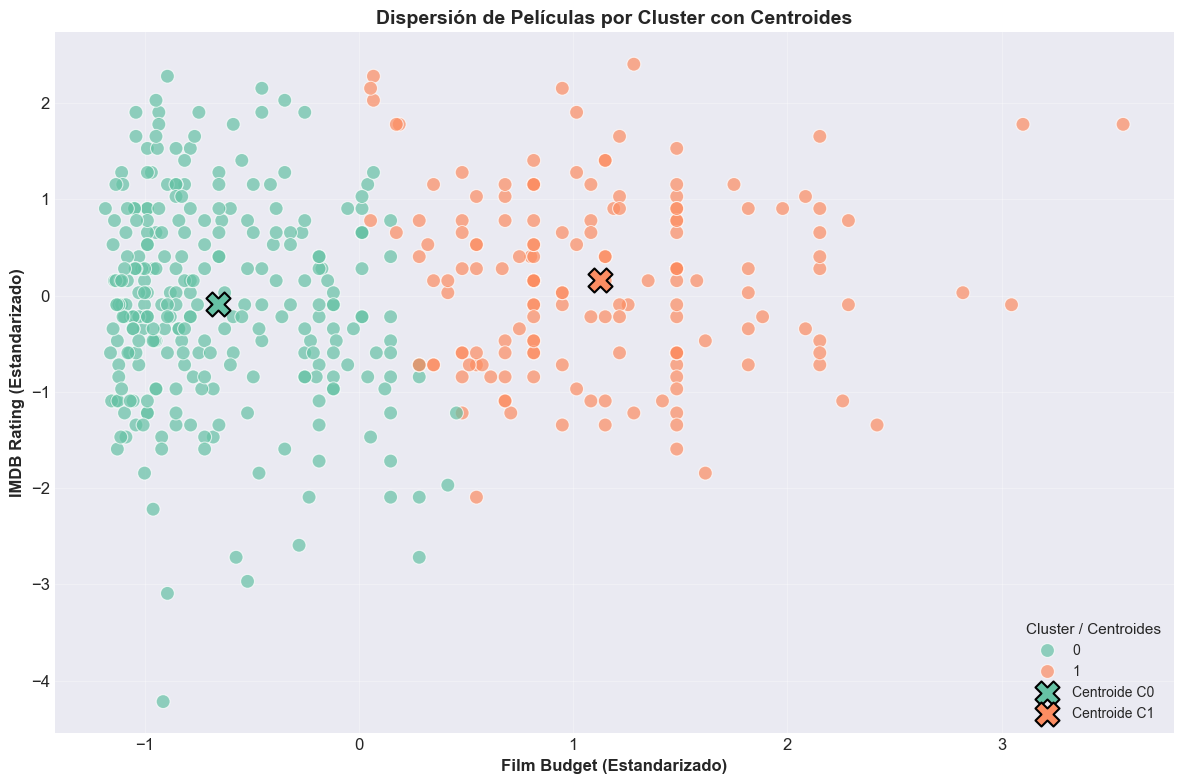

In [93]:
df_plot = df_cluster[['film_budget', 'imdb_rating']].copy()
df_plot['Cluster'] = labels.astype(str)  # convertir a str para colores categóricos


# Colores y orden de clusters
palette = sns.color_palette("Set2", n_colors=best_k)
cluster_order = [str(i) for i in range(best_k)]  # asegura que 0,1,2,... correspondan a colores


# Calcular centroides por cluster
centroids = np.array([
    df_plot.loc[df_plot['Cluster']==c, ['film_budget','imdb_rating']].mean().values
    for c in cluster_order
])


# Scatter plot
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_plot,
    x='film_budget',
    y='imdb_rating',
    hue='Cluster',
    palette=palette,
    hue_order=cluster_order,  # clave: controla el orden de colores
    s=100,
    alpha=0.7
)


# Graficar centroides
for i, (x, y) in enumerate(centroids):
    plt.scatter(x, y, color=palette[i], s=300, marker='X', edgecolor='k', linewidth=1.5, label=f'Centroide C{i}')


# Etiquetas y estilo
plt.xlabel('Film Budget (Estandarizado)', fontsize=12, fontweight='bold')
plt.ylabel('IMDB Rating (Estandarizado)', fontsize=12, fontweight='bold')
plt.title('Dispersión de Películas por Cluster con Centroides', fontsize=14, fontweight='bold')
plt.legend(title='Cluster / Centroides', fontsize=10, title_fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()


# Guardar gráfico
ruta_dispersion = os.path.join(graphics_folder, '02_Dispersion_Peliculas_Clusters.png')
plt.savefig(ruta_dispersion, dpi=300, bbox_inches='tight')
plt.show()

## Descripción e interpretacion:
En este gráfico tenemos la dispersión de las películas según presupuesto y rating IMDB, ambos estandarizados, pero los clusters no se formaron solo con estas dos variables.El género principal también forma parte del vector usado en el k-means mediante variables dummy, así que la separación que vemos aquí está influenciada indirectamente por el género. Aunque el eje x y el eje y solo muestran presupuesto y rating, los colores reflejan grupos que también comparten patrones de género o sea, dos películas pueden estar cerca en el plano presupuesto–rating, pero si son de géneros distintos, el modelo puede separarlas en clusters diferentes, esto explica por qué a veces se ven puntos de distintos colores relativamente cercanos

Los centroides entonces representan un perfil promedio que combina presupuesto típico, rating típico, y una composición de géneros dominante dentro del cluster.

Por ejemplo, un cluster que aparece con presupuesto alto puede estar dominado por géneros como acción o aventura, mientras que otro con presupuesto medio y buen rating puede concentrar drama o thriller, esa información no se ve explícita en el plano, pero sí está codificada en la asignación de clusters, por eso este gráfico no solo muestra una relación entre presupuesto y rating, sino que sirve para entender cómo el género modula esa relación, a manera de conclusion hay géneros que tienden a producir películas caras sin necesariamente mejores ratings,y otros que, con presupuestos más bajos, logran calificaciones altas.

## Analisis de tablas de perfiles de los clusters

Objetivo: Representar las variables implicadas en el algoritmo

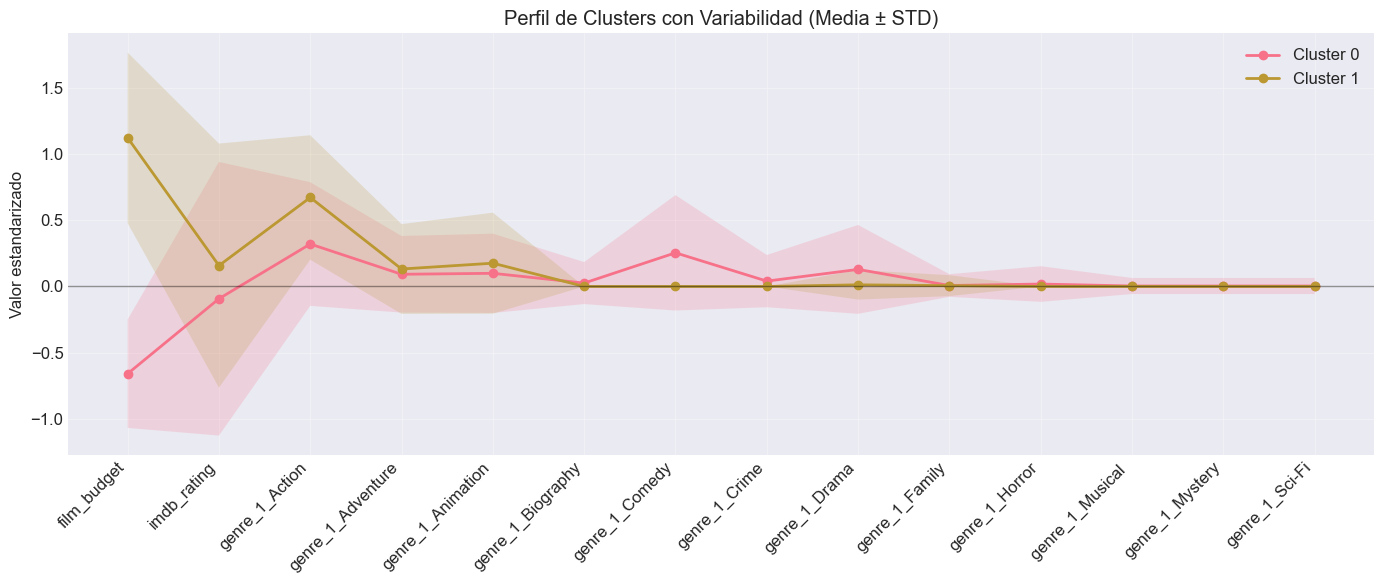

In [94]:
# df_cluster tiene las variables usadas en KMeans (ya estandarizadas + dummies)
df_profile = df_cluster.copy()
df_profile['Cluster'] = labels.astype(int)

# Calcular media y std por cluster
mean_profile = df_profile.groupby('Cluster').mean()
std_profile  = df_profile.groupby('Cluster').std()

features = mean_profile.columns
x = np.arange(len(features))

plt.figure(figsize=(14,6))

for c in mean_profile.index:
    mean_vals = mean_profile.loc[c].values
    std_vals  = std_profile.loc[c].values

    plt.plot(x, mean_vals, marker='o', linewidth=2, label=f'Cluster {c}')
    plt.fill_between(
        x,
        mean_vals - std_vals,
        mean_vals + std_vals,
        alpha=0.2
    )

plt.axhline(0, color='black', lw=1, alpha=0.4)
plt.xticks(x, features, rotation=45, ha='right')
plt.ylabel('Valor estandarizado')
plt.title('Perfil de Clusters con Variabilidad (Media ± STD)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretación

La tabla de perfiles de los clusters resume el comportamiento promedio de cada grupo en las dimensiones utilizadas para el clustering, todas ellas expresadas en valores estandarizados. Esto permite comparar directamente la importancia relativa de cada variable dentro y entre los clusters.

En primer lugar, se observa que las variables numéricas como el presupuesto y la calificación IMDB presentan patrones diferenciados entre los clusters. Valores positivos indican películas con características por encima del promedio global, mientras que valores negativos representan películas con presupuestos o ratings inferiores al promedio. La presencia de desviaciones estándar reducidas en estas dimensiones sugiere que los clusters son internamente consistentes y que estas variables contribuyen de manera estable a la separación de los grupos.

Por otro lado, las variables dummy asociadas al género principal muestran una influencia clara en la estructura de los clusters. Cuando un género presenta un valor medio elevado en un cluster y valores cercanos a cero o negativos en los demás, esto indica que dicho género actúa como un factor distintivo del grupo. Esta situación explica por qué películas con presupuestos y calificaciones similares pueden pertenecer a clusters distintos, ya que el género introduce una dimensión semántica adicional en el proceso de agrupamiento.

La comparación conjunta de medias y desviaciones permite además identificar el grado de homogeneidad de cada cluster. Clusters con bandas de variabilidad estrechas reflejan grupos bien definidos, mientras que aquellos con mayor dispersión indican una mayor heterogeneidad interna. Este análisis es clave para evaluar la solidez de los grupos obtenidos.

En conjunto, la tabla evidencia que el clustering no está determinado únicamente por diferencias numéricas en presupuesto o rating, sino por la interacción entre estas variables y la composición de géneros. Esto refuerza la idea de que los clusters representan tipos naturales de películas con características coherentes, y no divisiones artificiales generadas por el algoritmo.

# Resultados obtenidos del análisis de clustering

El análisis realizado permite identificar resultados concretos y relevantes sobre la estructura interna del conjunto de películas blockbuster. En primer lugar, el algoritmo de clustering logró separar las películas en grupos bien definidos, lo que indica que no todas las producciones de alto perfil siguen un mismo patrón de presupuesto, rating y género, sino que existen tipologías claras dentro del mercado.

Uno de los resultados más importantes es que el presupuesto emerge como una variable altamente discriminante entre clusters. Se observa que ciertos grupos concentran películas con presupuestos consistentemente por encima del promedio global, mientras que otros agrupan producciones con inversiones más moderadas. Esto sugiere la existencia de distintos modelos de blockbuster, donde un alto presupuesto no es el único camino para alcanzar visibilidad o impacto.

En relación con el rating, los resultados muestran que este no aumenta de forma proporcional al presupuesto. Algunos clusters presentan ratings promedio elevados a pesar de no ser los más costosos, lo que evidencia que la recepción del público y la crítica responde también a factores narrativos y de género, y no únicamente al nivel de inversión económica. Este hallazgo es clave, ya que rompe la idea de que mayor presupuesto implica automáticamente mejor valoración.

La inclusión del género principal aporta un resultado adicional de gran valor interpretativo. Los clusters no solo se diferencian por magnitudes numéricas, sino también por composición temática. Se identifican grupos donde ciertos géneros tienen una presencia dominante, lo que indica que el género actúa como un factor estructurante que influye tanto en el nivel de presupuesto asignado como en el desempeño en rating. Esto refuerza la noción de que los clusters representan perfiles reales de producción cinematográfica.

Otro resultado relevante es el grado de homogeneidad interna de los clusters. Algunos grupos presentan baja variabilidad en sus características, lo que indica modelos de películas bastante consistentes, mientras que otros muestran mayor dispersión, reflejando estrategias más diversas dentro de un mismo cluster. Esta diferencia interna permite distinguir entre clusters más “especializados” y otros más “flexibles”.

En conjunto, los resultados del análisis confirman que es posible segmentar las películas blockbuster en grupos naturales con significado práctico. Estos clusters reflejan distintos perfiles de producción y recepción, combinando presupuesto, rating y género de forma coherente. Más allá de la técnica utilizada, el resultado central es que el mercado de blockbusters no es homogéneo, sino que está compuesto por varios tipos de películas con características y comportamientos claramente diferenciables.